## Training Risk-Aware-VAE

### Load MNIST

In [1]:
import torch
from dataset import read_mnist
from torch.utils.data import DataLoader
from utils import *

torch.manual_seed(2)

In [2]:
mnist_train, mnist_val, mnist_test = read_mnist()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

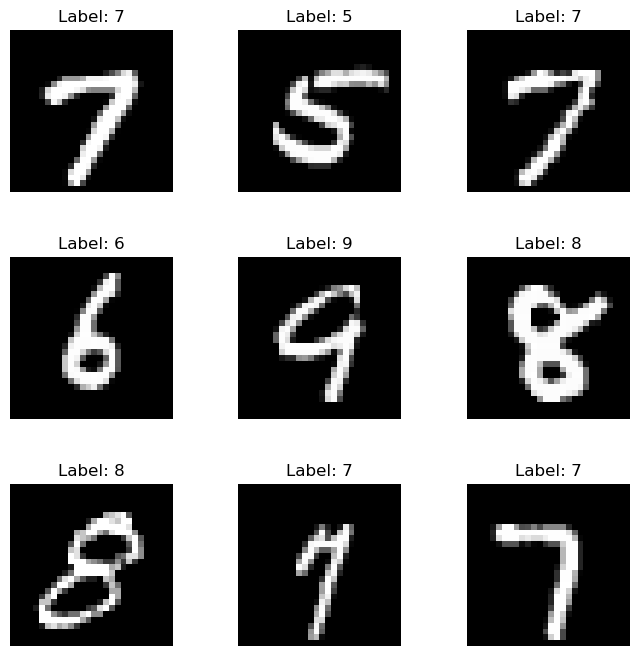

In [3]:
# some visualizations
train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
visualize_dataset_in_grid(train_features, train_labels)

### Train VAE

In [4]:
from train import train_VAE, vanilla_config, two_layer_config

In [5]:
vanilla_config = {"img_size": 28 * 28, 
                  "latent_dim": 2,
                  "layer_config": two_layer_config,
                  "subsample": 100,
                  "device": device,
                  "risk_aware": "neutral",
                  "epochs": 5}

In [6]:
vae_vanilla = train_VAE(vanilla_config, mnist_train, mnist_val)

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 36.19it/s]


Epoch: 1, train loss: 178.7105, dev loss: 162.4241


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 36.62it/s]


Epoch: 2, train loss: 158.4079, dev loss: 156.0937


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 36.63it/s]


Epoch: 3, train loss: 153.9464, dev loss: 153.9627


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:20<00:00, 36.12it/s]


Epoch: 4, train loss: 151.3408, dev loss: 151.2162


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:21<00:00, 35.40it/s]


Epoch: 5, train loss: 149.6263, dev loss: 149.8290


In [7]:
rs_config = {"img_size": 28 * 28, 
             "latent_dim": 2,
             "layer_config": two_layer_config,
             "subsample": 100,
             "device": device,
             "risk_aware": "seeking",
             "epochs": 5}

In [8]:
vae_rs = train_VAE(rs_config, mnist_train, mnist_val)

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:22<00:00, 34.05it/s]


Epoch: 1, train loss: 170.9491, dev loss: 125.3497


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:24<00:00, 30.91it/s]


Epoch: 2, train loss: 153.3275, dev loss: 118.0492


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:23<00:00, 31.46it/s]


Epoch: 3, train loss: 148.6661, dev loss: 114.6401


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:53<00:00, 14.05it/s]


Epoch: 4, train loss: 145.5562, dev loss: 112.3770


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.64it/s]


Epoch: 5, train loss: 143.3127, dev loss: 111.3525


Sanity check

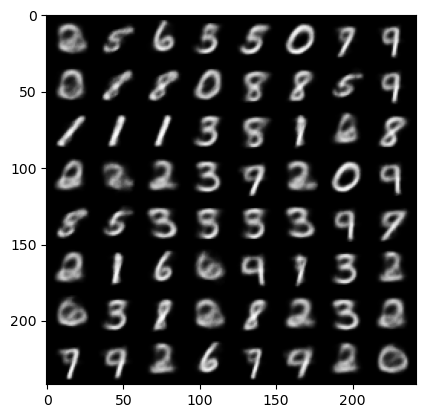

In [9]:
show_gen_img(vae_vanilla, 2, device)

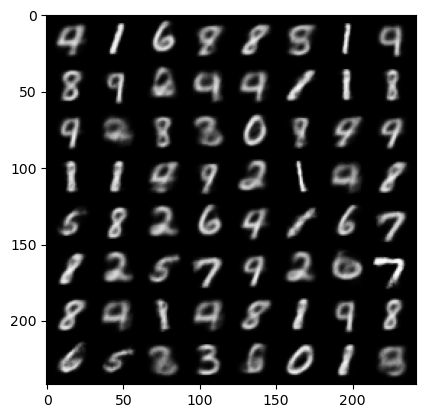

In [10]:
show_gen_img(vae_rs, 2, device)

### Model Evaluation

#### Using reconstruction loss as a metric

Pro: Allows evaluation of the quality of a single image

Con: Comparison can only be made with fixed pairs of input and output

Preparation

In [11]:
val_dataloader = DataLoader(mnist_val, batch_size=64, shuffle=True)

In [12]:
recon_samples_a, list_recon_loss_a = compute_recon_loss(vae_vanilla, val_dataloader, device)
recon_samples_b, list_recon_loss_b = compute_recon_loss(vae_rs, val_dataloader, device)

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:15<00:00, 12.22it/s]


##### Image/Sub-sample-wise comparison

Distribution of reconstruction loss

Model A: Loss minimum: 26.677104949951172, Loss maximum: 450.67510986328125
Model B: Loss minimum: 25.86857795715332, Loss maximum: 1778.3857421875


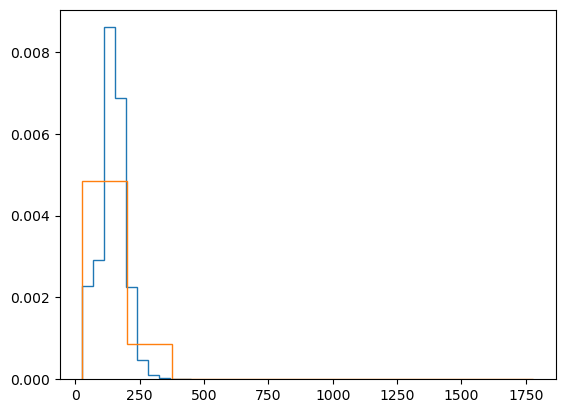

In [13]:
plot_metric(reorder(list_recon_loss_a, by="image"), reorder(list_recon_loss_b, by="image"), metric="Loss")

Plot 3 best images

In [14]:
best_imgs_a, best_imgs_loss_a = best_images(recon_samples_a, reorder(list_recon_loss_a, by="image"))
best_imgs_b, best_imgs_loss_b = best_images(recon_samples_b, reorder(list_recon_loss_b, by="image"))

Reconstruction loss: 26.677104949951172
Reconstruction loss: 26.82931900024414
Reconstruction loss: 27.030473709106445
Reconstruction loss: 27.13467788696289
Reconstruction loss: 27.139835357666016
Reconstruction loss: 27.175064086914062
Reconstruction loss: 27.190448760986328
Reconstruction loss: 27.24215316772461
Reconstruction loss: 27.492589950561523
Reconstruction loss: 27.49808120727539
Reconstruction loss: 25.86857795715332
Reconstruction loss: 25.87325668334961
Reconstruction loss: 25.885757446289062
Reconstruction loss: 25.905040740966797
Reconstruction loss: 25.912033081054688
Reconstruction loss: 25.928112030029297
Reconstruction loss: 25.965755462646484
Reconstruction loss: 25.97208023071289
Reconstruction loss: 25.986801147460938
Reconstruction loss: 26.002412796020508


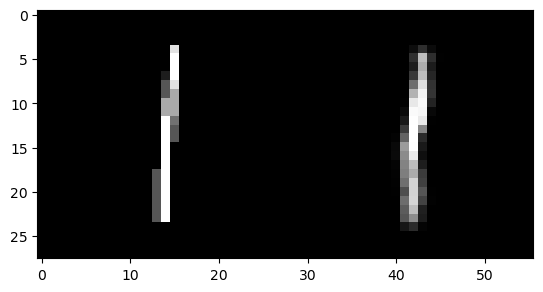

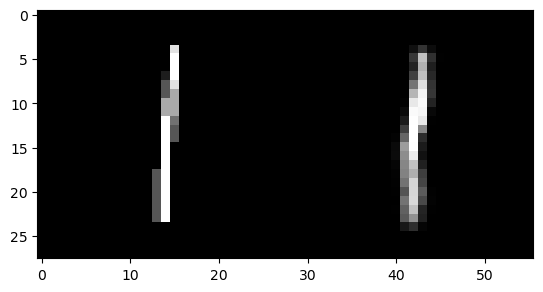

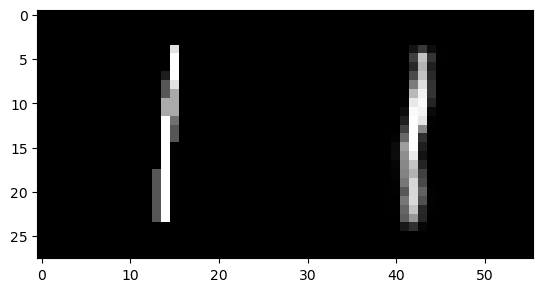

In [17]:
plot_best_images(best_imgs_a)

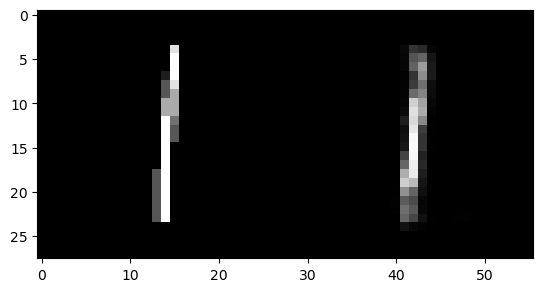

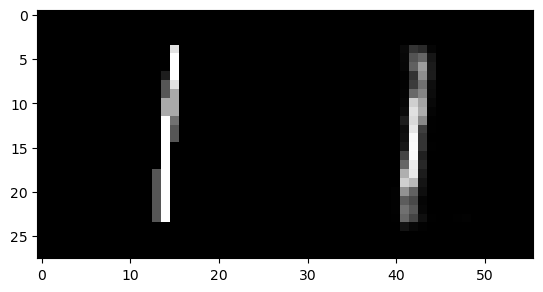

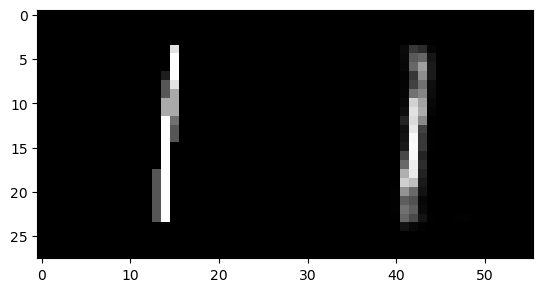

In [18]:
plot_best_images(best_imgs_b)

2 sample t-test for mean reconstruction loss in 10 best images

In [19]:
t_test(best_imgs_loss_a, best_imgs_loss_b)

Significant difference, t-statistics: 14.697695801171605, p-value: 1.8113379974135745e-11


##### Batch-wise comparison

Distribution of reconstruction loss

Model A: Loss minimum: 127.50531005859375, Loss maximum: 161.2773895263672
Model B: Loss minimum: 128.16610717773438, Loss maximum: 169.17189025878906


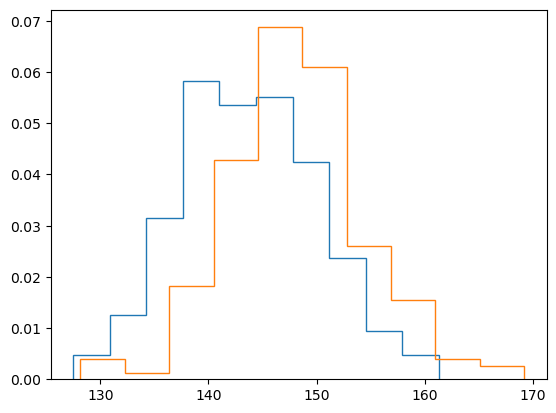

In [20]:
plot_metric(reorder(list_recon_loss_a, by="batch"), reorder(list_recon_loss_b, by="batch"), metric="Loss")

Plot images in best batch

In [21]:
best_batch_a, best_batch_loss_a = best_batch(recon_samples_a, reorder(list_recon_loss_a, by="batch"), reorder(list_recon_loss_a, by="image_nested"))
best_batch_b, best_batch_loss_b = best_batch(recon_samples_b, reorder(list_recon_loss_b, by="batch"), reorder(list_recon_loss_b, by="image_nested"))

Loss on best batch: 127.50531005859375
Loss on best batch: 128.16610717773438


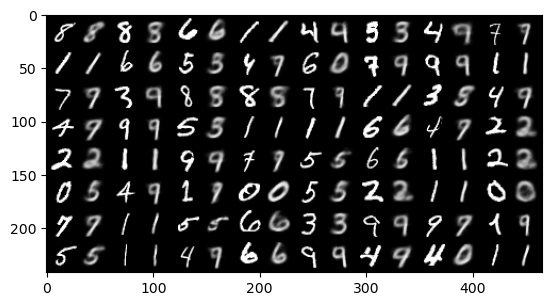

In [22]:
plot_best_batch(best_batch_a)

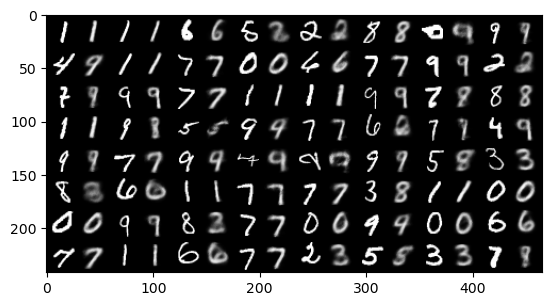

In [23]:
plot_best_batch(best_batch_b)

2 sample t-test for mean reconstruction loss in best batches

In [24]:
t_test(best_batch_loss_a, best_batch_loss_b)

No significant difference, t-statistics: -0.7224434802813736, p-value: 0.4700350633157051


#### Using 1NN and KMMD as metric

Pro: Allows evaluation of the quality of any image -> allows assessment of generative ability

Con: Comparison can only be made between batches

Preparation

In [25]:
list_samples_a, list_mu_real_a, list_mu_gen_a = generated_embedding(vae_vanilla, 2, device, val_dataloader)
list_samples_b, list_mu_real_b, list_mu_gen_b = generated_embedding(vae_rs, 2, device, val_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 80.58it/s]


In [26]:
list_acc_a = knn_by_batch(list_mu_real_a, list_mu_gen_a)
list_acc_b = knn_by_batch(list_mu_real_b, list_mu_gen_b)

In [27]:
list_mmd_a = mmd_by_batch(list_mu_real_a, list_mu_gen_a)
list_mmd_b = mmd_by_batch(list_mu_real_b, list_mu_gen_b)

Distribution of image quality

Model A: 1NN Accuracy minimum: 0.390625, 1NN Accuracy maximum: 0.75
Model B: 1NN Accuracy minimum: 0.3984375, 1NN Accuracy maximum: 0.6953125


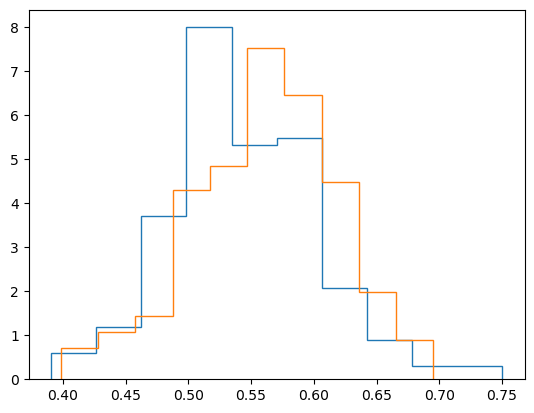

In [28]:
plot_metric(list_acc_a, list_acc_b, metric="1NN Accuracy")

Model A: KMMD minimum: 0.08056049048900604, KMMD maximum: 0.195184588432312
Model B: KMMD minimum: 0.07506520301103592, KMMD maximum: 0.19297243654727936


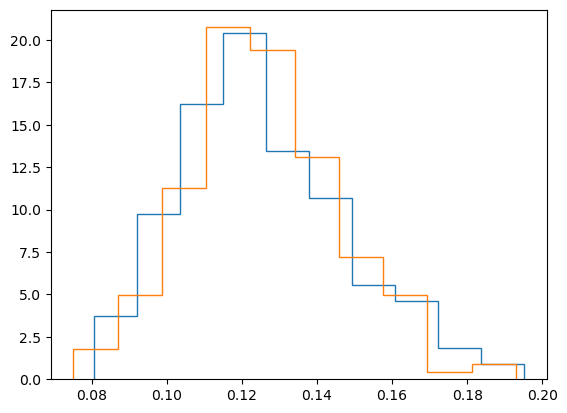

In [29]:
plot_metric(list_mmd_a, list_mmd_b, metric="KMMD")

Plot images in best batch

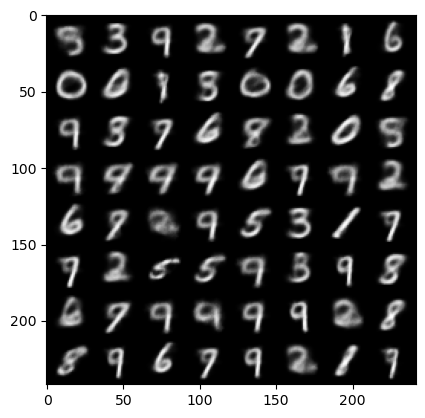

In [31]:
plot_metric_best_batch(list_samples_a, list_acc_a)

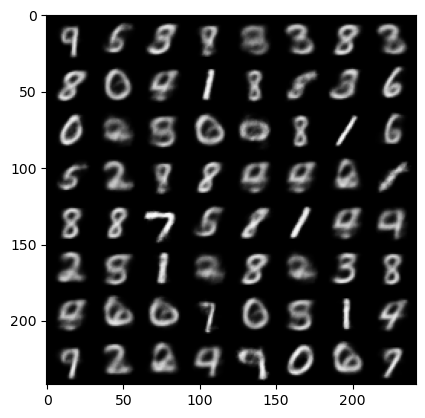

In [32]:
plot_metric_best_batch(list_samples_b, list_acc_b)

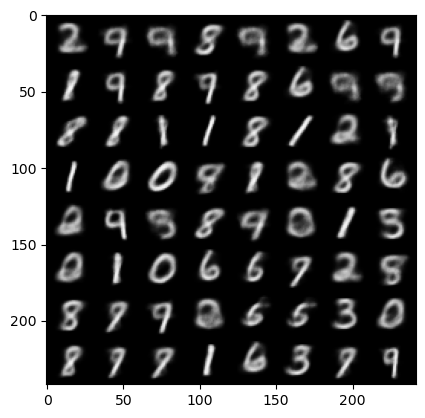

In [33]:
plot_metric_best_batch(list_samples_a, list_mmd_a)

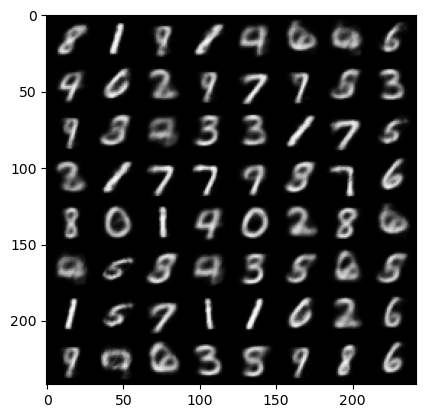

In [34]:
plot_metric_best_batch(list_samples_b, list_mmd_b)

2 sample t-test for image quality

In [35]:
t_test(list_acc_a, list_acc_b)

Significant difference, t-statistics: -2.5586429126824606, p-value: 0.010901168350411015


In [36]:
t_test(list_mmd_a, list_mmd_b)

No significant difference, t-statistics: -0.22520896423156242, p-value: 0.8219397192409174
